# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter= ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter= ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).
row_count = azdias.shape[0]
col_count = azdias.shape[1]
print("[Data Structure for General Population]")
print("Number of Rows    = {}".format(row_count))
print("Number of Columns = {}".format(col_count))
azdias.sample(10)
#azdias.info() #- a few columns with NaN , 4 columns with object type

[Data Structure for General Population]
Number of Rows    = 891221
Number of Columns = 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
163011,-1,2,2,5.0,1,5,1,4,4,3,...,2.0,4.0,2.0,1.0,2.0,4.0,3.0,3.0,5.0,5.0
428293,2,4,1,5.0,3,1,5,3,1,5,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,2.0,2.0,1.0
854088,-1,3,1,4.0,3,4,1,2,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,2.0,4.0,1.0
307402,3,3,2,NaN,3,2,5,1,1,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,4.0,8.0,3.0
65306,1,4,2,5.0,4,1,4,3,3,3,...,3.0,3.0,1.0,0.0,1.0,3.0,3.0,3.0,4.0,2.0
23159,0,4,1,6.0,4,1,5,1,1,4,...,1.0,3.0,3.0,2.0,4.0,3.0,1.0,4.0,8.0,5.0
260322,3,1,2,5.0,2,1,5,1,1,5,...,1.0,4.0,3.0,2.0,4.0,5.0,3.0,3.0,8.0,5.0
372342,-1,1,2,4.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,5.0,2.0
345130,-1,3,2,3.0,2,2,4,2,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,2.0
608400,-1,3,2,3.0,2,3,3,5,1,4,...,3.0,2.0,1.0,0.0,1.0,3.0,3.0,4.0,5.0,3.0


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
feat_info.info()
#feat_info.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [7]:
feat_info.sample(5)

,attribute,information_level,type,missing_or_unknown
42,ZABEOTYP,person,categorical,"[-1,9]"
77,PLZ8_ANTG3,macrocell_plz8,ordinal,[-1]
20,LP_STATUS_GROB,person,categorical,[0]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"


In [8]:
# Setting attribute column as index - it has all unique values and could help for data operations
feat_info.set_index('attribute', inplace= True)

In [9]:
feat_info.sample(5)

,information_level,type,missing_or_unknown
attribute,,,
ONLINE_AFFINITAET,region_rr1,ordinal,[]
KKK,region_rr1,ordinal,"[-1,0]"
SEMIO_DOM,person,ordinal,"[-1,9]"
ALTER_HH,household,interval,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

#### Find existing missing data (null)

In [10]:
# Find out how many columns have null values
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [11]:
# Count of columns with null values
(azdias.isnull().sum() == 0).sum()

32

In [12]:
# Total count of null and non null values
exist_null_count = azdias.isnull().sum().sum()
exist_nonull_count = azdias.notnull().sum().sum() 
print ("Existing Null Count = {} ; Existing Non-Null Count =  {}".format(exist_null_count,exist_nonull_count))

Existing Null Count = 4896838 ; Existing Non-Null Count =  70856947


In [13]:
# find % Null
print("Percentage of Existing Null Values {:.2f} %".format((exist_null_count) * 100 / (exist_nonull_count + exist_null_count))) 

Percentage of Existing Null Values 6.46 %


##### Conversion of  missing value codes to NaN

In [14]:
columns = azdias.columns # Get the list of all column names

In [15]:
feat_info

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]
FINANZ_SPARER,person,ordinal,[-1]
FINANZ_VORSORGER,person,ordinal,[-1]
FINANZ_ANLEGER,person,ordinal,[-1]
FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]


In [16]:
#Replace the values that have missing codes with NaN
for col in columns:
    # process the string that contains the missing value codes for the column - string is in feat_info dataframe
    miss_unk_vals = feat_info.loc[col]['missing_or_unknown'][1:-1].split(',') # split the string and eliminate square brackets
    #print(col,miss_unk_vals)
    if miss_unk_vals != ['']:
        list_miss_unk = [] # used to store the values with correct data type
        for val in miss_unk_vals:
            if val in ['X' , 'XX']:
                list_miss_unk.append(val) # store string as it is
            else:
                list_miss_unk.append(int(val)) # convert string to the integer number
        # Finally replace the dataframe column having missing value codes with NaN
        azdias[col] = azdias[col].replace(list_miss_unk,np.nan) 

In [17]:
# Find out how many columns have null values
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the dataset.

# Total count of null and non null values
new_null_count = azdias.isnull().sum().sum()
new_nonull_count = azdias.notnull().sum().sum() 
print ("New Null Count = {} ; New Non-Null Count =  {}".format(new_null_count,new_nonull_count))

# find % Null
print("Percentage of New Null Values {:.2f} %".format((new_null_count) * 100 / (new_nonull_count + new_null_count))) 


New Null Count = 8373929 ; New Non-Null Count =  67379856
Percentage of New Null Values 11.05 %


In [19]:
#  Find % missing values in each column - sort it in descending order
miss_val = round((azdias.isnull().sum() *100 / row_count).sort_values(ascending = False),2)

In [20]:
miss_val

TITEL_KZ                 99.76
AGER_TYP                 76.96
KK_KUNDENTYP             65.60
KBA05_BAUMAX             53.47
GEBURTSJAHR              44.02
ALTER_HH                 34.81
REGIOTYP                 17.74
KKK                      17.74
W_KEIT_KIND_HH           16.61
KBA05_ANTG4              14.96
KBA05_GBZ                14.96
MOBI_REGIO               14.96
KBA05_ANTG1              14.96
KBA05_ANTG2              14.96
KBA05_ANTG3              14.96
PLZ8_GBZ                 13.07
PLZ8_HHZ                 13.07
PLZ8_BAUMAX              13.07
PLZ8_ANTG4               13.07
PLZ8_ANTG1               13.07
PLZ8_ANTG3               13.07
PLZ8_ANTG2               13.07
SHOPPER_TYP              12.48
VERS_TYP                 12.48
HEALTH_TYP               12.48
NATIONALITAET_KZ         12.15
PRAEGENDE_JUGENDJAHRE    12.14
KBA13_ANZAHL_PKW         11.87
ANZ_HAUSHALTE_AKTIV      11.18
CAMEO_INTL_2015          11.15
                         ...  
RETOURTYP_BK_S            0.54
ONLINE_A

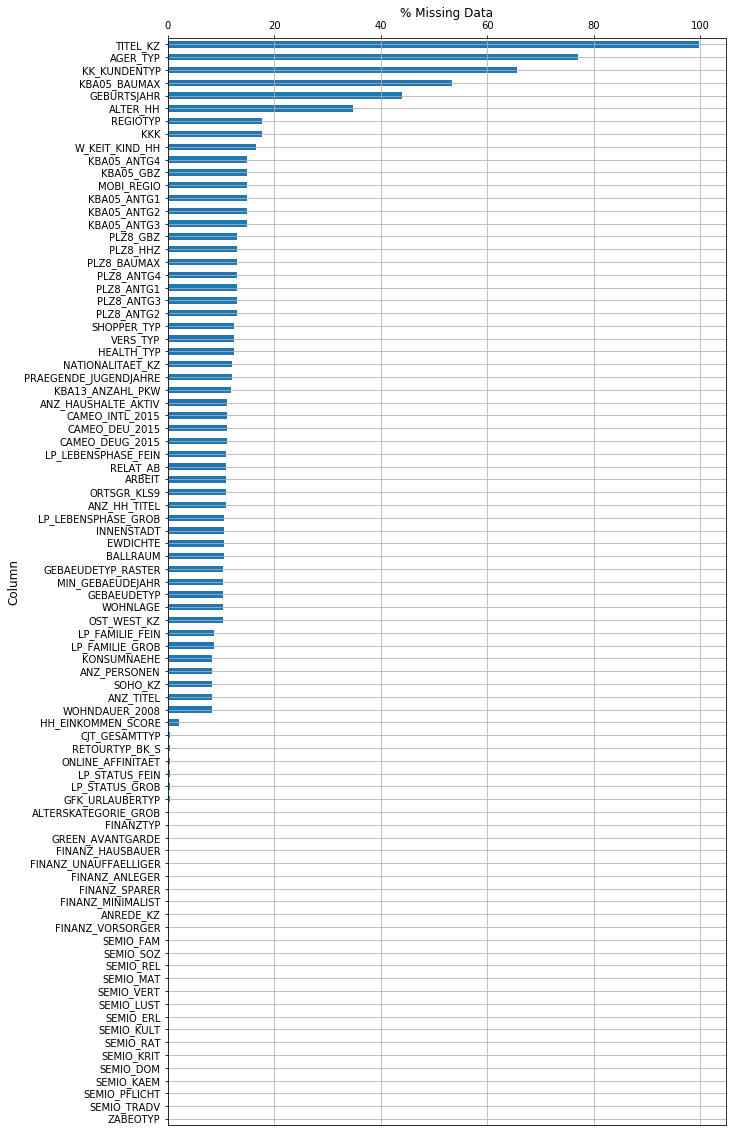

In [21]:
# Investigate patterns in the amount of missing data in each column.
fig = plt.figure()
ax = fig.add_subplot(111)
miss_val.plot(kind ='barh', figsize=(10,20),fontsize=10, grid=True)
plt.gca().invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.xlabel('% Missing Data',fontsize=12)
plt.ylabel('Column',fontsize=12)
#plt.title('Missing Data distribution')
plt.show()

In [22]:
# Let's try and see from a Group level - information level
df = miss_val.to_frame()
df.columns = ['%_Null']
df.index.name = 'Col'

In [23]:
df_feat = df.join(feat_info)

In [24]:
df_feat

,%_Null,information_level,type,missing_or_unknown
Col,,,,
TITEL_KZ,99.76,person,categorical,"[-1,0]"
AGER_TYP,76.96,person,categorical,"[-1,0]"
KK_KUNDENTYP,65.60,household,categorical,[-1]
KBA05_BAUMAX,53.47,microcell_rr3,mixed,"[-1,0]"
GEBURTSJAHR,44.02,person,numeric,[0]
ALTER_HH,34.81,household,interval,[0]
REGIOTYP,17.74,region_rr1,ordinal,"[-1,0]"
KKK,17.74,region_rr1,ordinal,"[-1,0]"
W_KEIT_KIND_HH,16.61,household,ordinal,"[-1,0]"


In [25]:
# List unique information levels
df_feat.information_level.value_counts()

person            43
macrocell_plz8     8
household          7
building           7
microcell_rr3      6
region_rr1         5
postcode           3
community          3
microcell_rr4      3
Name: information_level, dtype: int64

In [26]:
df_person = df_feat[(df_feat['information_level'] == 'person') & (df_feat['%_Null'] > 15)]
df_person.iloc[:,0:-1]

,%_Null,information_level,type
Col,,,
TITEL_KZ,99.76,person,categorical
AGER_TYP,76.96,person,categorical
GEBURTSJAHR,44.02,person,numeric


In [27]:
df_household = df_feat[(df_feat['information_level'] == 'household') & (df_feat['%_Null'] > 15)]
df_household.iloc[:,0:-1]

,%_Null,information_level,type
Col,,,
KK_KUNDENTYP,65.60,household,categorical
ALTER_HH,34.81,household,interval
W_KEIT_KIND_HH,16.61,household,ordinal


In [28]:
df_macrocell_plz8 = df_feat[(df_feat['information_level'] == 'macrocell_plz8') & (df_feat['%_Null'] > 15)]
df_macrocell_plz8.iloc[:,0:-1]

,%_Null,information_level,type
Col,,,


In [29]:
df_building = df_feat[(df_feat['information_level'] == 'building') & (df_feat['%_Null'] > 15)]
df_building.iloc[:,0:-1]

,%_Null,information_level,type
Col,,,


In [30]:
df_microcell_rr3 = df_feat[(df_feat['information_level'] == 'microcell_rr3') & (df_feat['%_Null'] > 15)]
df_microcell_rr3.iloc[:,0:-1]

,%_Null,information_level,type
Col,,,
KBA05_BAUMAX,53.47,microcell_rr3,mixed


In [31]:
df_region_rr1 = df_feat[(df_feat['information_level'] == 'region_rr1') & (df_feat['%_Null'] > 15)]
df_region_rr1.iloc[:,0:-1]

,%_Null,information_level,type
Col,,,
REGIOTYP,17.74,region_rr1,ordinal
KKK,17.74,region_rr1,ordinal


In [32]:
df_postcode = df_feat[(df_feat['information_level'] == 'postcode') & (df_feat['%_Null'] > 15)]
df_postcode.iloc[:,0:-1]

,%_Null,information_level,type
Col,,,


In [33]:
df_microcell_rr4 = df_feat[(df_feat['information_level'] == 'microcell_rr4') & (df_feat['%_Null'] > 15)]
df_microcell_rr4.iloc[:,0:-1]

,%_Null,information_level,type
Col,,,


In [34]:
df_community = df_feat[(df_feat['information_level'] == 'community') & (df_feat['%_Null'] > 15)]
df_community.iloc[:,0:-1]

,%_Null,information_level,type
Col,,,


In [35]:
df_feat[df_feat['%_Null'] > 30] # List columns that have more than 30% missing values

,%_Null,information_level,type,missing_or_unknown
Col,,,,
TITEL_KZ,99.76,person,categorical,"[-1,0]"
AGER_TYP,76.96,person,categorical,"[-1,0]"
KK_KUNDENTYP,65.60,household,categorical,[-1]
KBA05_BAUMAX,53.47,microcell_rr3,mixed,"[-1,0]"
GEBURTSJAHR,44.02,person,numeric,[0]
ALTER_HH,34.81,household,interval,[0]


In [36]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)

#Get a copy to work upon - leave original dataframe in tact
azdias_clean = azdias.copy()
# Drop the 6 columns that have more than 30% missing values
azdias_clean = azdias_clean.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],axis=1)
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

In [37]:
# Total count of missing and present values
new_null_count = azdias_clean.isnull().sum().sum()
new_nonull_count = azdias_clean.notnull().sum().sum() 
print ("Missing Values Count = {} ; Present Values Count =  {}".format(new_null_count,new_nonull_count))

# find % Null
print("Percentage of Missing Values {:.2f} %".format((new_null_count) * 100 / (new_nonull_count + new_null_count)))

Missing Values Count = 5035304 ; Present Values Count =  65371155
Percentage of Missing Values 7.15 %


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

- The objective of the exercise so far was to identify , convert and mark all the missing values in each of the columns. Now based on the % of missing values in the column - a decision has to be taken on which columns should be dropped. While an extremely high % of missing values is a consideration for dropping,it is important to assess if the column being dropped also contains very useful information that could not be found elsewhere - some of this is easy to decide and in some cases, we would need customer guidance. Ideally while we can recommend columns to be dropped - we should ideally consult with the customer to understand their perspective on the utility of information contained in sparse useful data.

For this dataset - here are the columns that have missing values above 20 %

TITEL_KZ	 - 99.76 %
AGER_TYP	 - 76.96 %
KK_KUNDENTYP - 65.60 %
KBA05_BAUMAX - 53.47 %
GEBURTSJAHR	 - 44.02 %
ALTER_HH	 - 34.81 %

1. Dropping 'TITEL_KZ' column : This is a very easy decision as close to 100% data is missing and the column indicates the Academic title flag (Dr./ Prof), which should not have a significant bearing on the customer persona.

2. Dropping 'AGER_TYP' column : This column has about 77% missing values and the column indicates - Best-ager typology (For aged people) - which seems to be specific sub classification of aged people.This column may be of significance for health /medicare provider other-wise does not seem very significant for other customer persona.

3. Dropping 'KK_KUNDENTYP' column - This column does not contain data for about 65% of cases- it indicates Consumer pattern over past 12 months - While this is good information to have, it would generate real value only if you could tag it with products or products category. That perhaps should need a more careful targetted approach rather than a mass mailers which are typically targetted based on the potential customer profile.For this project - we have lot of other features that should be good enough to generate classes of customers. Hence dropping.

4. Dropping 'KBA05_BAUMAX' column - This column does not contain data for about 53% of cases - indicates Most common building type within the microcell. This seems to indicate whether it is primarily a business area or residential area - while there are levels of classification for residential homes for business area there are none , also lot of residential family demographics seem to be covered in other features(columns). Hence dropping.

5. Dropping 'GEBURTSJAHR' column -  This column does not contain data for 44% cases - indicates Birth Year of the person. We can drop this as there is another column that captures the estimated age group. Most often age group information is sufficient for targeted marketing.

6. Dropping 'ALTER_HH' column - This column does not contain data for about 35% cases - indicates Birthdate of head of household - This does not seem to be useful for customer classification - having such a column may actually result in unnecessary overfitting of the model when training without any value. Hence dropping.

In general , we can notice that for all columns belonging to a particular 'information_level' , we have equal count of values except for  following information level entries : Person-level ,Household-level ,Building-level.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [38]:
# How much data is missing in each row of the dataset?
azdias_clean.isnull().sum(axis = 1).sort_values(ascending = False)

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64

In [39]:
#List count of missing values/row and Count of Rows that have those many missing values/row 
print("# Missing Values/Row  Vs   # Rows")
(azdias_clean.isnull().sum(axis = 1)).value_counts().sort_index()

# Missing Values/Row  Vs   # Rows


0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64

In [40]:
# Write code to divide the data into two subsets in terms of threshold based on the number of missing values in each row.

# See how much data is available for analysis for different threshold levels
print("% of rows with No missing values = {:.2f}".format(100*((azdias_clean.isnull().sum(axis=1) == 0).sum())/azdias_clean.shape[0]))
print("--------------------------------------------------------------------------------------")
# Based on the results seen above,the dataset does not have rows with more than 60% missing values
# Getting a sense of number of rows getting affected with increasing missing values
thresholds = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
for thresh_val in thresholds:
    length_miss = ((azdias_clean.isnull().sum(axis=1))> int(thresh_val*azdias_clean.shape[1])).sum()
    percent_missing = (length_miss/azdias_clean.shape[0])*100
    print("# of rows having > {:.2f}% missing values = {} ; Rows with missing values = {:.2f} % " .format(thresh_val*100,length_miss,percent_missing))

% of rows with No missing values = 69.93
--------------------------------------------------------------------------------------
# of rows having > 5.00% missing values = 206719 ; Rows with missing values = 23.20 % 
# of rows having > 10.00% missing values = 144112 ; Rows with missing values = 16.17 % 
# of rows having > 15.00% missing values = 109941 ; Rows with missing values = 12.34 % 
# of rows having > 20.00% missing values = 98934 ; Rows with missing values = 11.10 % 
# of rows having > 25.00% missing values = 94144 ; Rows with missing values = 10.56 % 
# of rows having > 30.00% missing values = 93384 ; Rows with missing values = 10.48 % 
# of rows having > 35.00% missing values = 93177 ; Rows with missing values = 10.45 % 
# of rows having > 40.00% missing values = 93151 ; Rows with missing values = 10.45 % 
# of rows having > 45.00% missing values = 75233 ; Rows with missing values = 8.44 % 
# of rows having > 50.00% missing values = 74113 ; Rows with missing values = 8.32 % 
# 

In [41]:
# Set a threshold for forming two datasets as needed
# Create 2 data frames one having rows with more than 15 % missing values in a row and the other with less than 15%

azdias_missvals_abvthresh = azdias_clean[(azdias_clean.isnull().sum(axis=1)) > int(0.15*azdias_clean.shape[1])]
azdias_missvals_belthresh = azdias_clean[(azdias_clean.isnull().sum(axis=1)) <= int(0.15*azdias_clean.shape[1])]
len_miss_abvthresh = len(azdias_missvals_abvthresh)
len_miss_belthresh = len(azdias_missvals_belthresh)
total = len_miss_abvthresh + len_miss_belthresh
#percent_missing = (length_miss/azdias_clean.shape[0])*100
print("# of Rows having > 15% missing values = {}" .format(len_miss_abvthresh))
print("# of Rows having <= 15% missing values = {}" .format(len_miss_belthresh))
print("Total Row Count  = {}" .format(total))

# of Rows having > 15% missing values = 109941
# of Rows having <= 15% missing values = 781280
Total Row Count  = 891221


In [42]:
azdias_clean.shape

(891221, 79)

In [43]:
(azdias_clean.isnull().sum(axis=1)> 0).sum()

268012

In [44]:
(azdias_clean.isnull().sum(axis=1) == 0).sum()

623209

In [45]:
# Compare the distribution of values for atleast five columns where there are no or few missing values, between the two subsets.

# find Features (Columns) that have less than 3% missing values
df_feat[df_feat['%_Null'] < 3]

,%_Null,information_level,type,missing_or_unknown
Col,,,,
HH_EINKOMMEN_SCORE,2.06,household,ordinal,"[-1,0]"
CJT_GESAMTTYP,0.54,person,categorical,[0]
RETOURTYP_BK_S,0.54,person,ordinal,[0]
ONLINE_AFFINITAET,0.54,region_rr1,ordinal,[]
LP_STATUS_FEIN,0.54,person,categorical,[0]
LP_STATUS_GROB,0.54,person,categorical,[0]
GFK_URLAUBERTYP,0.54,person,categorical,[]
ALTERSKATEGORIE_GROB,0.32,person,ordinal,"[-1,0,9]"
FINANZTYP,0.00,person,categorical,[-1]


In [46]:
def plotDistrib (col_name,df_abv_thresh,df_bel_thresh):
       
    plt.figure()
    plt.subplot(2,1,1)
    sns.countplot(x=col_name,data=df_bel_thresh)
    plt.title("Distribution - Missing values <= 15%")
    plt.subplot(2,1,2)
    sns.countplot(x=col_name ,data=df_abv_thresh)
    plt.title("Distribution - Missing values > 15%")
    plt.subplots_adjust(hspace = 1)


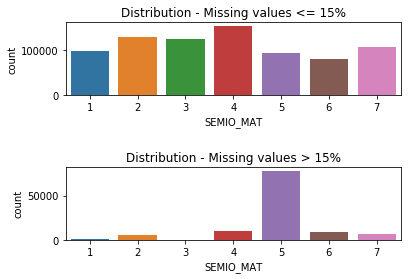

In [47]:
plotDistrib('SEMIO_MAT',azdias_missvals_abvthresh,azdias_missvals_belthresh)

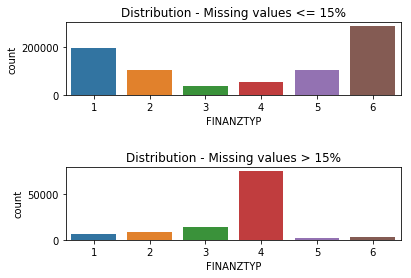

In [48]:
plotDistrib('FINANZTYP',azdias_missvals_abvthresh,azdias_missvals_belthresh)

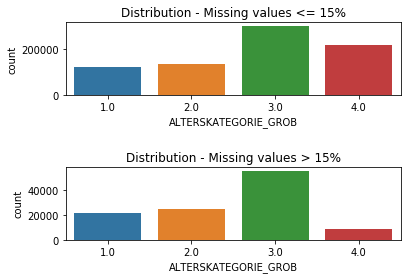

In [49]:
plotDistrib('ALTERSKATEGORIE_GROB',azdias_missvals_abvthresh,azdias_missvals_belthresh)

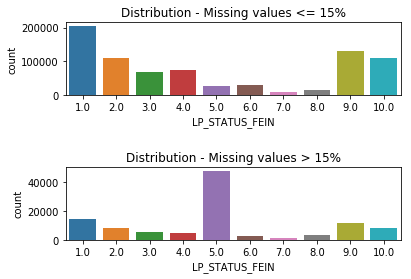

In [50]:
plotDistrib('LP_STATUS_FEIN',azdias_missvals_abvthresh,azdias_missvals_belthresh)

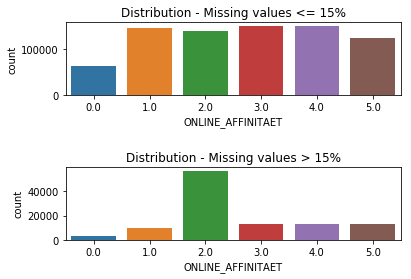

In [51]:
plotDistrib('ONLINE_AFFINITAET',azdias_missvals_abvthresh,azdias_missvals_belthresh)

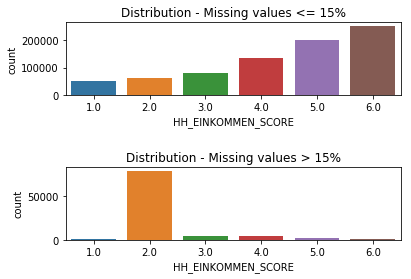

In [52]:
plotDistrib('HH_EINKOMMEN_SCORE',azdias_missvals_abvthresh,azdias_missvals_belthresh)

#### Discussion 1.1.3: Assess Missing Data in Each Row

* reporting your observations regarding missing data in rows. Are the data with lots of missing values qualitatively different from data with few or no missing values?

The data distribution in the plots between 2 datasets for all 6 columns do not indicate much of a similarity. Hence dropping 'All' the rows above the threshold for missing values is not really recommended.

The decision here is to fix how much % of missing values are we willing to accept in our data for analysis. We know that missing values will either have to be dropped or imputed with reasonable methods for our data analysis to proceed further. Almost 70% of data that we have does not have any missing values.So while it is tempting to just go ahead with to eliminate any effects due to bad imputations, a good idea may be to retain rows that have up to 15% missing data for imputations and drop the ones above that number. This will help us draw a balance between not loosing too much data and reducing the impact of incorrect imputations.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [53]:
# How many features are there of each data type? 

cols_rev = azdias_missvals_belthresh.columns.tolist()
df2 = feat_info.filter(items=cols_rev,axis=0)
df2['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [54]:
# List all columns(features) that have Categorical or Mixed data type 
dfcat_mix_cols = df2[(df2['type'] == 'categorical') | (df2['type'] == 'mixed')].sort_values(by='type')
dfcat_mix_cols = dfcat_mix_cols[['type','information_level']]
dfcat_mix_cols

,type,information_level
attribute,,
ANREDE_KZ,categorical,person
CAMEO_DEU_2015,categorical,microcell_rr4
CAMEO_DEUG_2015,categorical,microcell_rr4
OST_WEST_KZ,categorical,building
GEBAEUDETYP,categorical,building
ZABEOTYP,categorical,person
VERS_TYP,categorical,person
SOHO_KZ,categorical,person
SHOPPER_TYP,categorical,person


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [55]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
dfcat_cols = dfcat_mix_cols[dfcat_mix_cols['type'] == 'categorical']
cat_cols_list = dfcat_cols.index.tolist()
cat_cols_list

['ANREDE_KZ',
 'CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'OST_WEST_KZ',
 'GEBAEUDETYP',
 'ZABEOTYP',
 'VERS_TYP',
 'SOHO_KZ',
 'SHOPPER_TYP',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'LP_FAMILIE_GROB',
 'LP_FAMILIE_FEIN',
 'GREEN_AVANTGARDE',
 'GFK_URLAUBERTYP',
 'FINANZTYP',
 'CJT_GESAMTTYP',
 'LP_STATUS_FEIN']

In [56]:
binary_lev = []
multi_lev = []
count = 0
for col in cat_cols_list:
    count = azdias_missvals_belthresh[col].nunique()
    if count == 2:
        binary_lev.append(col)
    else:
        multi_lev.append(col)
    print("Feature = {} : Count of Distinct Values = {}".format(col,count))
    print(azdias_missvals_belthresh[col].unique())
    print()


Feature = ANREDE_KZ : Count of Distinct Values = 2
[2 1]

Feature = CAMEO_DEU_2015 : Count of Distinct Values = 44
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']

Feature = CAMEO_DEUG_2015 : Count of Distinct Values = 9
['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]

Feature = OST_WEST_KZ : Count of Distinct Values = 2
['W' 'O']

Feature = GEBAEUDETYP : Count of Distinct Values = 7
[ 8.  1.  3.  2.  6.  4.  5.]

Feature = ZABEOTYP : Count of Distinct Values = 6
[5 3 4 1 6 2]

Feature = VERS_TYP : Count of Distinct Values = 2
[  2.   1.  nan]

Feature = SOHO_KZ : Count of Distinct Values = 2
[ 1.  0.]

Feature = SHOPPER_TYP : Count of Distinct Values = 4
[  3.   2.   1.   0.  nan]

Feature = LP_STATUS_GROB : Count of Distinct Values = 5
[  1.   2.   4.   5.   3.  nan]

Feature = NATIONALITAET_KZ : Count of Distinc

In [57]:
# Print all Features with Binary levels 
print("Features(Columns) with Binary Levels")
print(binary_lev)

# OST_WEST_KZ has characters [W,O] -Need to convert to numbers, while others look good to retain
azdias_missvals_belthresh['OST_WEST_KZ'].replace(['O','W'],[0,1], inplace= True)
#azdias_missvals_belthresh.info()

Features(Columns) with Binary Levels
['ANREDE_KZ', 'OST_WEST_KZ', 'VERS_TYP', 'SOHO_KZ', 'GREEN_AVANTGARDE']


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [58]:
# Print all Features with Multi-levels
print("Features with Multi Levels - All")
print(multi_lev)
print()
# Drop Unrequired Features(columns) with multi levels
mul_lev_del = ['CAMEO_DEU_2015','LP_STATUS_FEIN','LP_FAMILIE_FEIN','GEBAEUDETYP']
azdias_missvals_belthresh = azdias_missvals_belthresh.drop(mul_lev_del,axis=1)
#azdias_missvals_belthresh.info()

Features with Multi Levels - All
['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'GEBAEUDETYP', 'ZABEOTYP', 'SHOPPER_TYP', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'FINANZTYP', 'CJT_GESAMTTYP', 'LP_STATUS_FEIN']



In [59]:
# Re-encode categorical variable(s) to be kept in the analysis.

# remove the names of dropped columns from multi_lev
for col in multi_lev:
    if col in mul_lev_del:
        multi_lev.remove(col)
print("Features with Multi Levels - After dropping")
print(multi_lev)
print()
# One-Hot encode remaining columns with multi-level categorical data
azdias_missvals_belthresh = pd.get_dummies(azdias_missvals_belthresh, columns = multi_lev, prefix=multi_lev)
azdias_missvals_belthresh.info()

Features with Multi Levels - After dropping
['CAMEO_DEUG_2015', 'ZABEOTYP', 'SHOPPER_TYP', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'LP_FAMILIE_GROB', 'GFK_URLAUBERTYP', 'FINANZTYP', 'CJT_GESAMTTYP']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781280 entries, 1 to 891220
Columns: 122 entries, ALTERSKATEGORIE_GROB to CJT_GESAMTTYP_6.0
dtypes: float64(42), int64(23), object(1), uint8(56)
memory usage: 461.1+ MB


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- Features(Columns) with Binary Level: 
  ANREDE_KZ, OST_WEST_KZ, VERS_TYP, SOHO_KZ, GREEN_AVANTGARDE
  
  Action : Changed encoding of values in column SOHO_KZ from string to numeric and the rest of the above columns - no change required.
  

- Features (Columns) with Multiple Levels:
  CAMEO_DEU_2015, CAMEO_DEUG_2015, GEBAEUDETYP, ZABEOTYP, SHOPPER_TYP, LP_STATUS_GROB, NATIONALITAET_KZ, LP_FAMILIE_GROB, LP_FAMILIE_FEIN, GFK_URLAUBERTYP, FINANZTYP, CJT_GESAMTTYP, LP_STATUS_FEIN
  
  Action :
  1. Drop Columns - LP_STATUS_FEIN , LP_FAMILIE_FEIN , CAMEO_DEU_2015 - The finer information available in these columns is also covered slightly broadly in columns LP_STATUS_GROB,LP_FAMILIE_GROB ,CAMEO_DEUG_2015 respectively. It is felt that too much finer information may not add that much overall value, compared to the increase in dimensions that will happen because of one-hot encoding.
  2. One-hot encode remaining columns above as they do not seem to have overlapping information covered elsewhere

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [60]:
# List all Mixed-Type Columns
dfcat_cols = dfcat_mix_cols[dfcat_mix_cols['type'] == 'mixed']
mix_cols_list = dfcat_cols.index.tolist()
mix_cols_list

['CAMEO_INTL_2015',
 'PRAEGENDE_JUGENDJAHRE',
 'LP_LEBENSPHASE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'WOHNLAGE',
 'PLZ8_BAUMAX']

In [61]:
for col in mix_cols_list:
    count = azdias_missvals_belthresh[col].nunique()
    print("Feature = {} : Count of Distinct Values = {}".format(col,count))
    print(azdias_missvals_belthresh[col].unique())
    print()


Feature = CAMEO_INTL_2015 : Count of Distinct Values = 21
['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25' nan
 '23' '31' '52' '35' '45' '44' '32']

Feature = PRAEGENDE_JUGENDJAHRE : Count of Distinct Values = 15
[ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]

Feature = LP_LEBENSPHASE_GROB : Count of Distinct Values = 12
[  6.   1.  nan  10.   2.   3.   5.   7.  12.  11.   9.   4.   8.]

Feature = LP_LEBENSPHASE_FEIN : Count of Distinct Values = 40
[ 21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.  25.
  13.  18.  31.  38.  35.  30.   7.  22.  14.  29.  24.  28.  37.  26.  39.
  27.  36.   9.  34.  33.  15.  11.  40.  16.  19.  17.]

Feature = WOHNLAGE : Count of Distinct Values = 8
[ 4.  2.  7.  3.  5.  1.  8.  0.]

Feature = PLZ8_BAUMAX : Count of Distinct Values = 5
[  1.   2.  nan   4.   5.   3.]



###### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

Here is the mapping of what the 15 distinct levels represent

- 1: 40s - war years (Mainstream, E+W)
- 2: 40s - reconstruction years (Avantgarde, E+W)
- 3: 50s - economic miracle (Mainstream, E+W)
- 4: 50s - milk bar / Individualisation (Avantgarde, E+W)
- 5: 60s - economic miracle (Mainstream, E+W)
- 6: 60s - generation 68 / student protestors (Avantgarde, W)
- 7: 60s - opponents to the building of the Wall (Avantgarde, E)
- 8: 70s - family orientation (Mainstream, E+W)
- 9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

We need to construct 2 columns out of this that represent the 'Decade' and the 'Movement'

In [62]:
# For Decade - Map 15 values to 6 - since there are six decades from 40's to 90's
dec_dict = {1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}

# For movement there are only 2 values (Binary) - Avantgarde & Mainstream - that can be mapped to 1 or 0 respectively
mov_dict = {1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}

# Add a new Column 'Decade' and store the above new mapped values in dec_dict
azdias_missvals_belthresh['DECADE'] = azdias_missvals_belthresh['PRAEGENDE_JUGENDJAHRE'].map(dec_dict)

# Add a new Column 'AvantGarde' and store the above new mapped values in mov_dict
azdias_missvals_belthresh['AVANTGARDE'] = azdias_missvals_belthresh['PRAEGENDE_JUGENDJAHRE'].map(mov_dict)

# Now Drop PRAEGENDE_JUGENDJAHRE column from dataframe
azdias_missvals_belthresh.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)

In [63]:
azdias_missvals_belthresh.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,FINANZTYP_5,FINANZTYP_6,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,DECADE,AVANTGARDE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,1,0,90.0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,90.0,1.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,1,0,1,0,0,0,0,70.0,0.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1,0,0,0,0,0,1,0,70.0,0.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,50.0,0.0


#### Investigate "CAMEO_INTL_2015" and engineer two new variables.
##### The two columns : Wealth and Life_Stage , below are the Values and mapping :
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement

In [64]:
azdias_missvals_belthresh['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', nan, '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [65]:
# Add a new column WEALTH and store the first digit of value at column 'CAMEO_INTL_2015'
azdias_missvals_belthresh['WEALTH'] = azdias_missvals_belthresh['CAMEO_INTL_2015'].map(lambda x: (int(x)//10) if not pd.isnull(x) else x)

# Add a new column LIFE_STAGE and store the first digit of value at column 'CAMEO_INTL_2015'
azdias_missvals_belthresh['LIFE_STAGE'] = azdias_missvals_belthresh['CAMEO_INTL_2015'].map(lambda x: (int(x) % 10) if not pd.isnull(x) else x)

# Now Drop CAMEO_INTL_2015 column from dataframe
azdias_missvals_belthresh.drop('CAMEO_INTL_2015',axis=1,inplace=True)

In [66]:
azdias_missvals_belthresh.sample(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,DECADE,AVANTGARDE,WEALTH,LIFE_STAGE
847641,3.0,2,3,2,3,5,1,3,0,3.0,...,0,0,0,0,0,1,70.0,0.0,2.0,5.0
500079,4.0,2,3,1,5,1,2,5,1,2.0,...,1,0,0,0,0,0,60.0,1.0,4.0,3.0
777200,4.0,2,2,1,4,4,1,5,0,2.0,...,0,1,0,0,0,0,50.0,0.0,4.0,5.0
266770,2.0,2,1,5,2,3,4,4,0,2.0,...,0,0,0,1,0,0,90.0,0.0,4.0,1.0
176189,1.0,1,1,4,3,5,4,4,1,1.0,...,0,0,0,0,0,1,90.0,1.0,4.0,4.0


In [67]:
# Drop the other mixed category columns - LP_LEBENSPHASE_GROB,LP_LEBENSPHASE_FEIN,WOHNLAGE,PLZ8_BAUMAX
azdias_missvals_belthresh.drop(['LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN','WOHNLAGE','PLZ8_BAUMAX'],axis=1,inplace=True)
azdias_missvals_belthresh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781280 entries, 1 to 891220
Columns: 120 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(41), int64(23), uint8(56)
memory usage: 449.2 MB


In [68]:
#azdias_missvals_belthresh.columns.tolist()

#### Discussion 1.2.2: Engineer Mixed-Type Features

Reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?

- Feature PRAEGENDE_JUGENDJAHRE : Engineered this Column to two Columns - DECADE & AVANTGARDE and dropped PRAEGENDE_JUGENDJAHRE
- Feature CAMEO_INTL_2015 : Engineered this Column to two Columns WEALTH & LIFE_STAGE and dropped CAMEO_INTL_2015

- Features LP_LEBENSPHASE_GROB,LP_LEBENSPHASE_FEIN - Dropped Columns. Absence of a clear and consistent separation between levels in individual columns, also both cover some inforation but differ in terms of level of details - one has more finer level of details
- Feature WOHNLAGE - Dropped Column. It is not very clear whether the intent is to capture the quality of neighbourhood or urban/rural. Also Does not have enough levels for Rural neighbourhood to make it a meaningful new feature
- Feature PLZ8_BAUMAX  - Dropped column. The PLZ8 Macrocell category of features have information only about residential area. However this feature has just one level that indicates about business area. It does not make sense to create a separate new feature for that, also all the other levels in this feature are covered by other features in PLZ8 Macrocell.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

- All done !

In [68]:
# check if all columns are OK !
azdias_missvals_belthresh.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781280 entries, 1 to 891220
Data columns (total 120 columns):
ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                int64
FINANZ_MINIMALIST        int64
FINANZ_SPARER            int64
FINANZ_VORSORGER         int64
FINANZ_ANLEGER           int64
FINANZ_UNAUFFAELLIGER    int64
FINANZ_HAUSBAUER         int64
GREEN_AVANTGARDE         int64
HEALTH_TYP               float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                int64
SEMIO_FAM                int64
SEMIO_REL                int64
SEMIO_MAT                int64
SEMIO_VERT               int64
SEMIO_LUST               int64
SEMIO_ERL                int64
SEMIO_KULT               int64
SEMIO_RAT                int64
SEMIO_KRIT               int64
SEMIO_DOM                int64
SEMIO_KAEM               int64
SEMIO_PFLICHT            int64
SEMIO_TRADV              int64
SOHO_KZ                  float64
VERS_TYP                 float64
ANZ_PERSONEN             float64
ANZ_TITE

#### Looks Good ! All 120 columns displayed .. all are numeric

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [69]:
def clean_data(df,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    #1.convert missing value codes into NaNs
    
    for col in df.columns:
        # process the string that contains the missing value codes for the column - string is in feat_info dataframe
        miss_vals = feat_info.loc[col]['missing_or_unknown'][1:-1].split(',') # split the string and eliminate square brackets
        #print(col,miss_unk_vals)
        if miss_vals != ['']:
            list_miss_vals = [] # used to store the values with correct data type
            for val in miss_vals:
                if val in ['X' , 'XX']:
                    list_miss_vals.append(val) # store string as it is
                else:
                    list_miss_vals.append(int(val)) # convert number in string type to the integer 
            # Finally replace the dataframe column having missing value codes with NaN
            df[col] = df[col].replace(list_miss_vals,np.nan) 
    
    #2. remove selected columns and rows, ...
   
    # create a copy of dataframe to process on
    df_clean = df.copy()
    print("Before Processing.. data size = ({},{})".format(df.shape[0],df.shape[1]))
    # Drop the 6 columns we dropped in General data set
    df_clean = df_clean.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],axis=1)
    #Drop rows with more than 15% missing values
    df_low_missvals = df_clean[(df_clean.isnull().sum(axis=1)) <= int(0.15*df_clean.shape[1])]
    
    #return rows with more than 15% missing values - needed for section 3.3
    df_high_missvals = df_clean[(df_clean.isnull().sum(axis=1)) > int(0.15*df_clean.shape[1])]
    
    #3. select, re-encode, and engineer column values.
   
    # Engineering Categorical Features with Binary Level 
    # OST_WEST_KZ has characters [W,O] -Need to convert to numbers, while others look good to retain
    df_clean = df_low_missvals
    df_clean['OST_WEST_KZ'].replace(['O','W'],[0,1], inplace= True)

    # Engineering Categorical Features with multi-level values
    # Drop Unrequired Features(columns) with multi levels
    mul_lev_cols_del = ['CAMEO_DEU_2015','LP_STATUS_FEIN','LP_FAMILIE_FEIN','GEBAEUDETYP']
    df_clean =  df_clean.drop(mul_lev_cols_del,axis=1)
    # One-Hot encode remaining columns with multi-level categorical data
    cols_encode = ['CAMEO_DEUG_2015','ZABEOTYP','SHOPPER_TYP','LP_STATUS_GROB','NATIONALITAET_KZ',
                      'LP_FAMILIE_GROB', 'GFK_URLAUBERTYP', 'FINANZTYP', 'CJT_GESAMTTYP']
    df_clean = pd.get_dummies(df_clean, columns=cols_encode, prefix=cols_encode)
    
    #Engineer Categorical Feature with mixed data types 
    #Engineer PRAEGENDE_JUGENDJAHRE column
    # For Decade - Map 15 values to 6 - since there are six decades from 40's to 90's
    dec_dict = {1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}
    # For movement there are only 2 values (Binary) - Avantgarde & Mainstream - that can be mapped to 1 or 0 respectively
    mov_dict = {1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}
    # Add a new Column 'Decade' and store the above new mapped values in dec_dict
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(dec_dict)
    # Add a new Column 'AvantGarde' and store the above new mapped values in mov_dict
    df_clean['AVANTGARDE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(mov_dict)
    # Now Drop PRAEGENDE_JUGENDJAHRE column from dataframe
    df_clean.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
    #Engineer CAMEO_INTL_2015 column
    # Add a new column WEALTH and store the first digit of value at column 'CAMEO_INTL_2015'
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015'].map(lambda x: (int(x)//10) if not pd.isnull(x) else x)
    # Add a new column LIFE_STAGE and store the first digit of value at column 'CAMEO_INTL_2015'
    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015'].map(lambda x: (int(x) % 10) if not pd.isnull(x) else x)
    # Now Drop CAMEO_INTL_2015 column from dataframe
    df_clean.drop('CAMEO_INTL_2015',axis=1,inplace=True)
    # Drop the other mixed category columns - LP_LEBENSPHASE_GROB,LP_LEBENSPHASE_FEIN,WOHNLAGE,PLZ8_BAUMAX
    df_clean.drop(['LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN','WOHNLAGE','PLZ8_BAUMAX'],axis=1,inplace=True)

    print("After Processing.. data size = ({},{})".format(df_clean.shape[0],df_clean.shape[1]))
   
    # Return the cleaned dataframe and rows with high missing values
    return df_clean,df_high_missvals
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [70]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.

total_mVal = azdias_missvals_belthresh.isnull().sum().sum()
total_val =azdias_missvals_belthresh.shape[0]*azdias_missvals_belthresh.shape[1]
print("% missing vals = {:.2f}".format((total_mVal/total_val) * 100))

# Rows with missing values
tot_rows_miss_val = (azdias_missvals_belthresh.isnull().sum(axis=1) > 0).sum()
percent_missing = (tot_rows_miss_val/azdias_missvals_belthresh.shape[0])*100
print("# of rows having missing values = {} ; % of Rows with missing values = {:.2f} % " .format(tot_rows_miss_val,percent_missing))

# columns with missing values
azdias_missvals_belthresh.columns[azdias_missvals_belthresh.isnull().any()]

% missing vals = 0.57
# of rows having missing values = 158069 ; % of Rows with missing values = 20.23 % 


Index(['ALTERSKATEGORIE_GROB', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'VERS_TYP',
       'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ',
       'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'DECADE', 'AVANTGARDE',
       'WEALTH', 'LIFE_STAGE'],
      dtype='object')

In [71]:
# Apply feature scaling to the general population demographics data.

# Create an imputer that replaces NaN with the mean value of the feature by columns (axis=0)
mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
# Train and apply the imputer on the dataset
azdias_new = mean_imputer.fit_transform(azdias_missvals_belthresh)

# Make a dataframe that have only those rows of dataset that do not have any missing value
azdias_bthresh = azdias_missvals_belthresh.dropna(axis=0) 

# fit a scaler to this reduced clean dataset
scaler = StandardScaler()
scaler.fit(azdias_bthresh)

# Now apply the scaler on the imputed dataset
azdias_new = scaler.transform(azdias_new)
azdias_new = pd.DataFrame(azdias_new,columns=azdias_missvals_belthresh.columns)


In [72]:
azdias_bthresh.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,DECADE,AVANTGARDE,WEALTH,LIFE_STAGE
count,623211.000000,623211.000000,623211.000000,623211.000000,623211.000000,623211.000000,623211.000000,623211.000000,623211.000000,623211.000000,...,623211.000000,623211.000000,623211.000000,623211.000000,623211.000000,623211.000000,623211.000000,623211.000000,623211.000000,623211.000000
mean,2.792539,1.511210,3.057799,2.677010,3.451435,2.770214,2.563092,3.169594,0.234627,2.207485,...,0.117082,0.181646,0.190953,0.258192,0.128135,0.123992,73.097506,0.234627,3.326599,2.875793
std,1.026487,0.499875,1.360776,1.469262,1.388873,1.448797,1.372307,1.365482,0.423766,0.758645,...,0.321519,0.385553,0.393052,0.437640,0.334240,0.329572,14.515378,0.423766,1.457814,1.499303
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,4.000000,3.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.000000,0.000000,5.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.000000,1.000000,5.000000,5.000000


In [73]:
azdias_new.sample(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,DECADE,AVANTGARDE,WEALTH,LIFE_STAGE
757493,0.202108,-1.022678,-0.042475,0.219832,0.394972,-1.221852,0.318375,-0.856544,1.806125,1.044646,...,-0.364154,-0.471132,2.058371,-0.589964,-0.383362,-0.376220,0.475530,1.806125,-1.595951,0.749820
146265,1.176305,-1.022678,-0.042475,-1.141397,1.114980,-1.221852,-0.410325,1.340485,-0.553672,-0.273495,...,-0.364154,-0.471132,-0.485821,-0.589964,-0.383362,2.658017,-0.902320,-0.553672,0.461926,-1.251111
167488,1.176305,0.977825,1.427276,-1.141397,1.114980,-1.221852,-0.410325,-0.124201,1.806125,-0.273495,...,-0.364154,2.122546,-0.485821,-0.589964,-0.383362,-0.376220,-0.902320,1.806125,-1.595951,0.749820
426578,1.176305,-1.022678,0.692400,-1.141397,1.114980,-1.221852,-0.410325,1.340485,-0.553672,-1.591635,...,2.746088,-0.471132,-0.485821,-0.589964,-0.383362,-0.376220,-0.902320,-0.553672,0.461926,0.749820
409498,-0.772089,-1.022678,-0.777350,1.581061,-1.765054,-0.531624,1.047076,-0.856544,-0.553672,-0.273495,...,-0.364154,-0.471132,-0.485821,-0.589964,-0.383362,2.658017,1.164455,-0.553672,-0.909992,-0.584134


In [74]:
azdias_new.shape

(781280, 120)

### Discussion 2.1: Apply Feature Scaling

- The overall % of missing values in the dataset is very low (0.54%).Also the max % of missing values/column on an average is very low  - except 3 columns that are at about 7% ,about 90% of columns do not have more than 1% missing values.
On the other hand about 20% rows have nulls - hence dropping all the rows with na is not a good option given the above facts.


- Hence it was decided to :
 1. Impute all missing values in the columns of the existing dataset by replacing them with respective column mean.
 2. Fit a scaler on a version of the dataset in which all missing values were removed.
 3. Apply this scaler on the imputed dataset

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [75]:
# Apply PCA to the data.
pca = PCA() 
azdias_pca = pca.fit_transform(azdias_new)

vals = pca.explained_variance_ratio_
n_comps =len(vals) # number of computed components

indices = np.arange(n_comps)

In [76]:
pca.components_.shape

(120, 120)

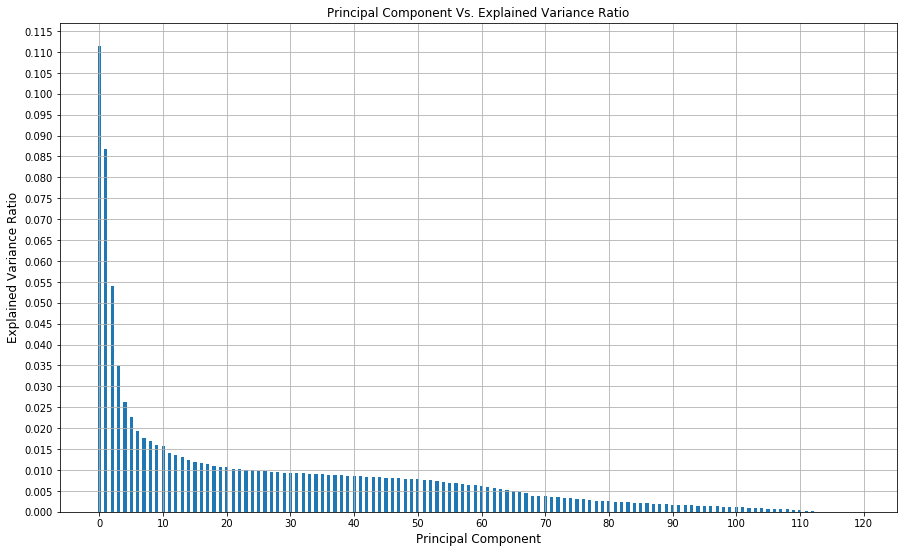

In [77]:
#Investigate the variance accounted for by each principal component.

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
plt.style.use('default')
ax.bar(indices, vals,width=0.5);
ax.set_xticks(np.arange(0, 127, step=10))
ax.set_yticks(np.arange(0, 0.12, step=0.005))
ax.grid(which = 'major')
plt.xlabel('Principal Component',fontsize=12)
plt.ylabel('Explained Variance Ratio',fontsize=12)
plt.title('Principal Component Vs. Explained Variance Ratio');


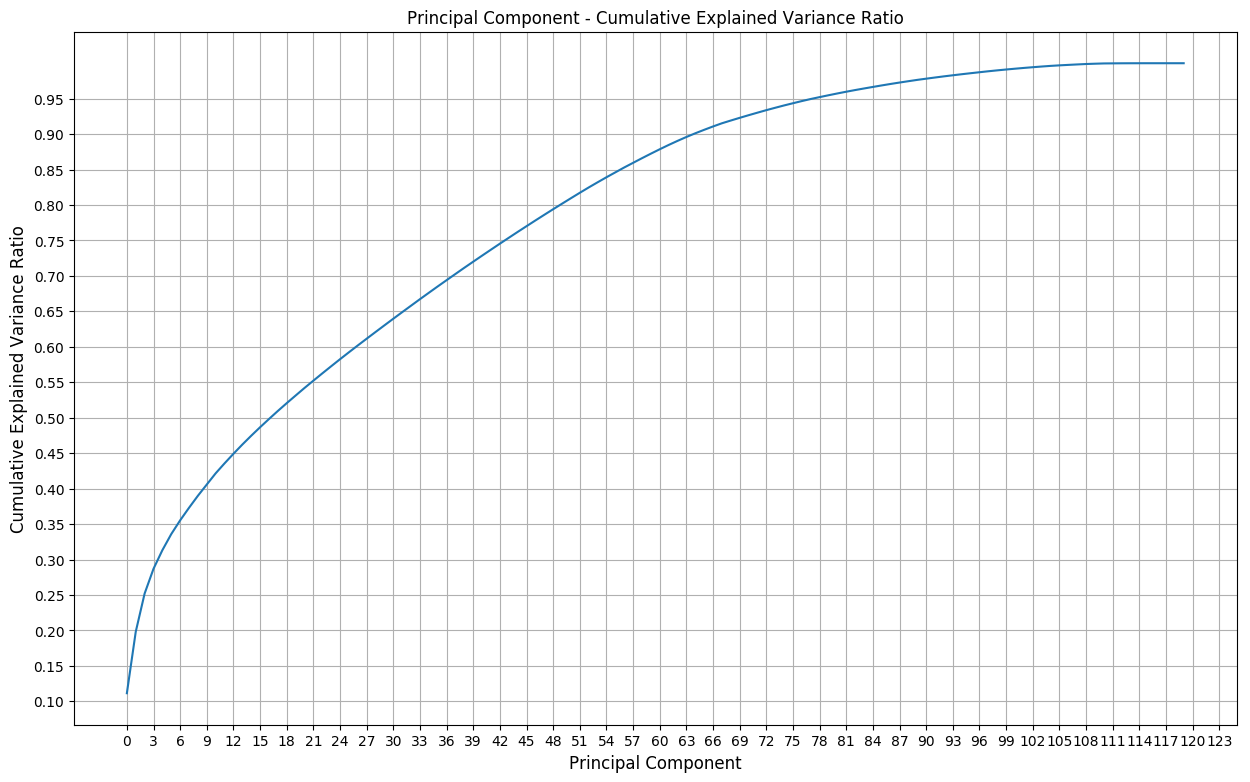

In [78]:
cumsum_vals = np.cumsum(vals)
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(np.arange(0, 127, step=3))
ax.set_yticks(np.arange(0, 1.0, step=0.05))
ax.grid(which = 'major')
ax.plot(cumsum_vals)
plt.xlabel('Principal Component',fontsize=12)
plt.ylabel('Cumulative Explained Variance Ratio',fontsize=12)
plt.title('Principal Component - Cumulative Explained Variance Ratio');


In [79]:
cumsum_vals_5 = []
pc = []
print("{:<6s}{:>17s}{:>17s}".format ('PC #','Explained Variance','Cumulative sum'))
for ind in np.arange(0,len(cumsum_vals),5):
    print("{:<6d}{:>17.2f}{:>18.2f}".format(ind+1,100*vals[ind],100*cumsum_vals[ind]))
    cumsum_vals_5.append(cumsum_vals[ind])
    pc.append(ind)


PC #  Explained Variance   Cumulative sum
1                 11.15             11.15
6                  2.27             33.59
11                 1.58             42.16
16                 1.20             48.66
21                 1.07             54.20
26                 0.98             59.23
31                 0.93             63.96
36                 0.90             68.52
41                 0.85             72.86
46                 0.81             77.01
51                 0.77             80.96
56                 0.69             84.61
61                 0.62             87.86
66                 0.49             90.61
71                 0.37             92.67
76                 0.31             94.36
81                 0.25             95.74
86                 0.21             96.87
91                 0.17             97.82
96                 0.14             98.59
101                0.11             99.23
106                0.08             99.70
111                0.04           

In [80]:
df_azdias_pca = pd.DataFrame(azdias_pca)
df_azdias_pca.head(5)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,4.819656,-2.723606,-2.857420,0.315023,-1.112404,0.507918,3.082918,2.652799,-0.070446,-1.443102,...,-0.112438,-0.012705,-0.160555,0.005918,0.028412,-0.003605,4.084608e-10,2.162853e-10,-2.211434e-11,-2.134008e-13
1,-0.143727,-0.695118,-3.499975,1.801913,-2.908039,-1.146683,-0.541422,0.739401,-1.194272,-1.309705,...,-0.024210,-0.005217,0.001666,-0.001941,-0.013823,0.007085,1.171842e-10,-3.077515e-11,-5.161028e-11,6.200129e-13
2,-4.805022,1.173832,-1.184727,-1.897100,1.385577,-1.807988,-0.607743,-0.312319,0.866598,0.445308,...,0.577396,0.310845,-0.068662,-0.003009,0.014401,-0.030663,3.559242e-10,-1.762385e-10,-6.795497e-11,7.590589e-12
3,0.175107,0.306661,3.116223,1.115037,1.057976,3.415384,0.556817,-2.501527,-2.762749,-0.105299,...,-0.062438,0.030667,-0.069406,-0.001949,-0.012997,0.015792,2.832443e-10,-7.024167e-11,1.398919e-10,-6.097791e-12
4,-0.626294,-0.790778,-0.754838,-2.606844,-3.814580,-0.133674,0.965731,-1.310706,0.279931,0.548133,...,-0.115151,-0.010272,-0.023947,-0.010516,-0.018366,0.013381,-5.661114e-11,3.389490e-11,2.554734e-11,3.221529e-11


In [81]:
# Re-apply PCA to the data while selecting for number of components to retain.
# ncomponents = 20 - captures slightly over 50% of total variance
# ncomponents = 60 - captures slightly over 85% of total variance

In [82]:
pca_20 = PCA(n_components=20,random_state=42)
azdias_pca_20 = pca_20.fit_transform(azdias_new)

vals_20 = pca_20.explained_variance_ratio_
n_comps_20 =len(vals) # number of computed components
cumsum_vals_20 = np.cumsum(vals_20)
indices = np.arange(n_comps_20)
cumsum_vals_all = []
pc = []
print("{:<6s}{:>17s}{:>17s}".format ('PC #','Explained Variance %','Cumulative sum %'))
for ind in np.arange(0,len(cumsum_vals_20)):
    print("{:<6d}{:>17.2f}{:>18.2f}".format(ind+1,100*vals_20[ind],100*cumsum_vals_20[ind]))
    cumsum_vals_all.append(cumsum_vals_20[ind])
    pc.append(ind)

PC #  Explained Variance % Cumulative sum %
1                 11.15             11.15
2                  8.67             19.82
3                  5.39             25.21
4                  3.49             28.70
5                  2.63             31.32
6                  2.27             33.59
7                  1.93             35.53
8                  1.77             37.30
9                  1.69             38.99
10                 1.58             40.57
11                 1.55             42.12
12                 1.40             43.51
13                 1.32             44.84
14                 1.29             46.13
15                 1.20             47.33
16                 1.17             48.50
17                 1.14             49.64
18                 1.10             50.74
19                 1.07             51.81
20                 1.04             52.84


In [83]:
df_azdias_pca_20 = pd.DataFrame(azdias_pca_20)
df_azdias_pca_20.head(5)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,4.819718,-2.723907,-2.857727,0.305991,-1.096693,0.440781,2.958302,2.700883,0.023833,-1.388279,-0.354262,-1.018695,0.557418,0.083696,0.635156,-2.009765,-0.096311,-0.636830,2.141059,0.800070
1,-0.143742,-0.695261,-3.498347,1.797541,-2.877181,-1.197923,-0.520140,0.754530,-0.971472,-1.095953,-0.497065,0.773014,-0.546486,0.926167,2.533466,-0.404505,-1.527985,-0.147801,0.502097,-1.598850
2,-4.804970,1.174186,-1.185381,-1.888583,1.329638,-1.810783,-0.553048,-0.178563,0.869824,0.489026,-0.611059,-0.647306,-0.187564,-0.943496,0.125703,-0.898965,0.276348,-0.085965,-1.154544,0.071632
3,0.175155,0.306409,3.117952,1.107436,1.082952,3.403564,0.474754,-2.409072,-2.779066,-0.223502,0.604861,1.882909,-0.724159,1.964103,0.334179,1.807549,-0.461655,0.604371,0.805044,-2.461574
4,-0.626330,-0.790530,-0.756660,-2.606213,-3.840947,-0.122256,1.007849,-1.291878,0.084315,0.332690,1.105519,-2.134845,1.450013,1.063213,0.818034,0.809224,1.288938,0.485415,-1.878742,0.951125


In [81]:
# Refitting PCA for 60 principal components for further use
pca_60 = PCA(n_components=60,random_state=42)
azdias_pca_60 = pca_60.fit_transform(azdias_new)
vals_60 = pca_60.explained_variance_ratio_
n_comps_60 =len(vals) # number of computed components
cumsum_vals_60 = np.cumsum(vals_60)
indices = np.arange(n_comps_60)
cumsum_vals_10 = []
pc = []
print("{:<6s}{:>17s}{:>17s}".format ('PC #','Explained Variance %','Cumulative sum %'))
for ind in np.arange(0,len(cumsum_vals_60),2):
    print("{:<6d}{:>17.2f}{:>18.2f}".format(ind+1,100*vals_60[ind],100*cumsum_vals_60[ind]))
    cumsum_vals_10.append(cumsum_vals_60[ind])
    pc.append(ind)

PC #  Explained Variance % Cumulative sum %
1                 11.15             11.15
3                  5.39             25.21
5                  2.63             31.33
7                  1.94             35.53
9                  1.69             39.00
11                 1.58             42.16
13                 1.35             44.92
15                 1.24             47.46
17                 1.16             49.82
19                 1.10             52.06
21                 1.07             54.20
23                 1.02             56.25
25                 1.00             58.25
27                 0.96             60.19
29                 0.94             62.09
31                 0.93             63.96
33                 0.92             65.80
35                 0.90             67.62
37                 0.88             69.40
39                 0.87             71.15
41                 0.85             72.86
43                 0.84             74.54
45                 0.83         

In [82]:
df_azdias_pca_60 = pd.DataFrame(azdias_pca_60)
df_azdias_pca_60.head(5)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,4.819655,-2.723605,-2.857459,0.314754,-1.112733,0.508210,3.084198,2.656237,-0.069999,-1.444494,...,4.798789,2.150504,0.590893,1.700770,-2.193452,-1.787365,0.120010,-0.580663,1.163304,1.026798
1,-0.143728,-0.695116,-3.499929,1.801960,-2.907535,-1.146856,-0.539966,0.730065,-1.193502,-1.307635,...,-0.196010,-0.010296,-2.218711,-0.151445,0.021248,0.006816,0.726559,-0.005824,1.043693,0.700687
2,-4.805021,1.173828,-1.184710,-1.896991,1.385763,-1.808213,-0.607761,-0.313975,0.868522,0.444672,...,0.605004,0.816230,-0.246373,0.204468,0.194466,-1.650204,-1.172971,-0.172716,-0.074518,0.433475
3,0.175107,0.306656,3.116281,1.115204,1.058692,3.415160,0.557403,-2.509604,-2.761198,-0.106453,...,-0.696774,-0.272303,0.435626,1.127984,-0.021177,0.072085,-0.620630,-0.066511,1.086807,0.534773
4,-0.626295,-0.790774,-0.754832,-2.606940,-3.814569,-0.133358,0.966750,-1.314744,0.280079,0.549174,...,0.985826,1.954499,-0.056030,-0.081113,-0.083688,0.460864,0.139952,-0.322204,0.356615,1.570770


### Discussion 2.2: Perform Dimensionality Reduction


The cumulative sum of the explained variance plot demonstrates approximately 3 different traversals:

- For Principal components 1  to 20   - the plot seems to be exponential -  Captures approx 50%  explained variance
- For Principal components 21 to 60   - the plot seems to be linear-ish. -  Captures approx 51% to 85% explained variance
- For Principal components 60 to 127 - the plot seems to be again exponential. - Captures 86% to 100 % explained variance.

I am selecting the first 60 principal components since it covers about 85% of explained variance and also it seems like a good choice that helps to reduce the feature count by more than 50%, hence reduce the computation time and memory requirements


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [83]:
def get_pc_features(feat_names, pca, pc_num):
    '''
    Inputs - List containing feature names, the PCA object, Number of the Principal Component
    Returns - For the referrred PC, sorted positive weight features, sorted negative weighted features  are returned
    '''

    # Principal Components
    prin_comps = ['PC{}'.format(i) for i in range(1,len(pca.components_)+1)]

    # Weights of individual features that define a PC
    df_feat_weights = pd.DataFrame(np.round(pca.components_, 4),columns=feat_names)
    df_feat_weights.index = prin_comps

    
    feat_weights  = df_feat_weights.iloc[pc_num - 1, :] # select all columns for the referred PC number
    weights_pos = feat_weights[feat_weights > 0].sort_values(ascending=False)
    weights_neg = feat_weights[feat_weights < 0].sort_values(ascending=True) # Most - ve feature weight should be at top

    return weights_pos,weights_neg


In [84]:
pca_60.components_.shape

(60, 120)

In [85]:
pca_60.explained_variance_ratio_.shape

(60,)

In [86]:
# Map weights for the first principal component to corresponding feature names and then print the linked values,sorted by weight.
weights_pos,weights_neg = get_pc_features(azdias_new.columns,pca_60,1)

# diplay top 10 positive and negative weighted features
display(weights_pos.head(10),weights_neg.head(10))

LP_STATUS_GROB_1.0    0.2013
HH_EINKOMMEN_SCORE    0.1965
PLZ8_ANTG3            0.1897
WEALTH                0.1888
PLZ8_ANTG4            0.1815
EWDICHTE              0.1633
ORTSGR_KLS9           0.1630
FINANZ_HAUSBAUER      0.1536
FINANZ_SPARER         0.1456
FINANZTYP_1           0.1358
Name: PC1, dtype: float64

FINANZ_MINIMALIST    -0.2129
MOBI_REGIO           -0.2085
KBA05_ANTG1          -0.1923
PLZ8_ANTG1           -0.1876
KBA05_GBZ            -0.1861
KONSUMNAEHE          -0.1435
PLZ8_GBZ             -0.1379
INNENSTADT           -0.1342
LP_STATUS_GROB_4.0   -0.1213
LIFE_STAGE           -0.1139
Name: PC1, dtype: float64

In [87]:
# Map weights for the second principal component to corresponding feature names and then print the linked values,sorted by weight.
weights_pos,weights_neg = get_pc_features(azdias_new.columns,pca_60,2)

# diplay top 10 positive and negative weighted features
display(weights_pos.head(10),weights_neg.head(10))

ALTERSKATEGORIE_GROB    0.2249
FINANZ_VORSORGER        0.2117
ZABEOTYP_3              0.2037
SEMIO_ERL               0.1861
SEMIO_LUST              0.1585
RETOURTYP_BK_S          0.1545
W_KEIT_KIND_HH          0.1250
FINANZ_HAUSBAUER        0.1165
CJT_GESAMTTYP_2.0       0.1056
FINANZTYP_5             0.0939
Name: PC2, dtype: float64

DECADE                  -0.2292
SEMIO_REL               -0.2172
FINANZ_SPARER           -0.2165
FINANZ_UNAUFFAELLIGER   -0.2155
SEMIO_TRADV             -0.2006
FINANZ_ANLEGER          -0.1963
SEMIO_PFLICHT           -0.1935
SEMIO_KULT              -0.1704
ONLINE_AFFINITAET       -0.1681
SEMIO_RAT               -0.1538
Name: PC2, dtype: float64

In [88]:
# Map weights for the third principal component to corresponding feature names and then print the linked values, sorted by weight.

weights_pos,weights_neg = get_pc_features(azdias_new.columns,pca_60,3)

# diplay top 10 positive and negative weighted features
display(weights_pos.head(10),weights_neg.head(10))

SEMIO_VERT           0.3312
SEMIO_SOZ            0.2605
SEMIO_FAM            0.2595
SEMIO_KULT           0.2473
FINANZTYP_5          0.1368
FINANZ_MINIMALIST    0.1346
SHOPPER_TYP_0.0      0.1224
ZABEOTYP_1           0.1120
SEMIO_REL            0.1075
RETOURTYP_BK_S       0.0858
Name: PC3, dtype: float64

ANREDE_KZ         -0.3549
SEMIO_KAEM        -0.3170
SEMIO_DOM         -0.2887
SEMIO_KRIT        -0.2695
SEMIO_ERL         -0.2019
SEMIO_RAT         -0.1675
FINANZ_ANLEGER    -0.1636
FINANZTYP_1       -0.1099
SHOPPER_TYP_2.0   -0.0937
FINANZ_SPARER     -0.0700
Name: PC3, dtype: float64

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

- The first 3 Principal Components account for 25.21%  of overall varianace , with the first principal component accounting for 11.15% of the overall variance. Summarily the first 19 principal components account for 50 % variance and first 57 principal components account for 85 % variance. In general the contribution of a principal component in capturing the overall variance drops exponentially as we move away from PC1 onwards.

We know that each principal component is defined by a sum of individual weighted features. In this exercise , on analyzing the first 3 principal component, here is what we understand :

- First Principal Component:
     - The top 5 positive weighted features - LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,WEALTH,PLZ8_ANTG4 . These are indicators for Earning/Income, Social Status, House Density
     - The top 5 negative weighted features -FINANZ_MINIMALIST,MOBI_REGIO,KBA05_ANTG1,PLZ8_ANTG1,KBA05_GBZ - These are indicators for Financial Frugality, People on the move and areas with Low residential density

 
- Second Principal Component:
     - The top 5 positive weighted features - ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,SEMIO_ERL,SEMIO_LUST . These are indicators for Age,individual mindset towards spending  - these are indicators of people who are willing to try out different things,experiences - in general ,positive spending potential
     - The top 5 negative weighted features -DECADE,SEMIO_REL,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,SEMIO_TRADV - These are indicators for Generation and individual mindset towards spending - these indicators are for people who are traditional, simple living and inconspicous people.
 
- Third Principal Component:
     - The top 5 positive weighted features - SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_KULT,FINANZTYP_5 . These are indicators for mindset of people who have a cultural ,social and family orientation and also want to try new things.
     - The top 5 negative weighted features -ANREDE_KZ,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_ERL - These are indicators of Male/Female and people who value their individualism over everything else - combat, dominate, criticise.
 
 
- In summary - the first principal component seems to primarily capture the earning/social status and residential density of the area where the person stays. The second principal component primarily seems to capture the age-range and spending potential of people. The third component seems to primarily capture the gender & nature of people - extrovert/social/open  or individualistic

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [94]:
# Over a number of different cluster counts,run k-means clustering on the pca transformed dataset 

scores = []
nclusters = [2,3,4,5,6,7,8,9,10,11,12,13,17,21,25]
for k in nclusters:
    kmeans = KMeans(n_clusters = k, random_state=42)
    model = kmeans.fit(azdias_pca_60)
     # compute the average distance within a cluster
    score = np.abs(model.score(azdias_pca_60))
    print("Cluster {}  Avg. Distance = {:.0f}".format(k,score))
    scores.append(score)
  

Cluster 2  Avg. Distance = 74879096
Cluster 3  Avg. Distance = 70674685
Cluster 4  Avg. Distance = 68071401
Cluster 5  Avg. Distance = 66476957
Cluster 6  Avg. Distance = 65049682
Cluster 7  Avg. Distance = 63773842
Cluster 8  Avg. Distance = 62607410
Cluster 9  Avg. Distance = 61640507
Cluster 10  Avg. Distance = 60952544
Cluster 11  Avg. Distance = 60336202
Cluster 12  Avg. Distance = 59952759
Cluster 13  Avg. Distance = 59273565
Cluster 17  Avg. Distance = 57396188
Cluster 21  Avg. Distance = 56036962
Cluster 25  Avg. Distance = 54787770


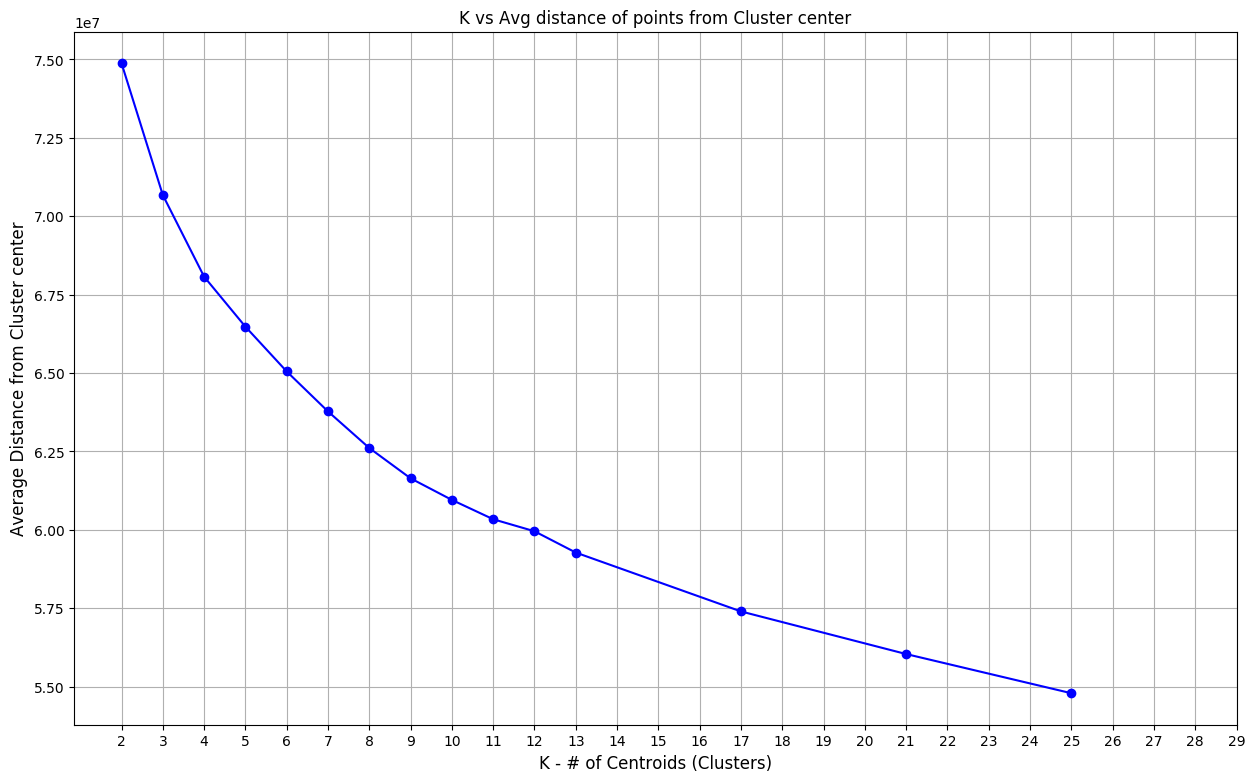

In [95]:
# Investigate the change in within-cluster distance across number of clusters.

fig = plt.figure(figsize=(15,9))
#plt.style.use('default')
ax = fig.add_subplot(1,1,1)   
plt.plot(nclusters,scores,marker='o', color='blue')
ax.set_xticks(np.arange(2, 30), minor=False);  
ax.grid(which = 'major')
ax.set_xlabel("K - # of Centroids (Clusters)",fontsize=12)
ax.set_ylabel("Average Distance from Cluster center",fontsize=12);
plt.title("K vs Avg distance of points from Cluster center");


In [89]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population demographics data.
# Selecting number of clusters , K = 9
kmeans_9 = KMeans(n_clusters=9, random_state=42)
pop_clusters = kmeans_9.fit_predict(azdias_pca_60)

In [90]:
pop_clusters.shape

(781280,)

### Discussion 3.1: Apply Clustering to General Population

- Looking at the above plot of avg distance vs the number of clusters - it can be seen that the average distance with cluster changes rapidly for first few number of clusters and then the rate of change or the slope starts decreases with respect to increasing values of K. The value of K at which we see the slope reducing gradually is at K= 9. It can be seen by looking at the computed distances for different values of K as well as the plot. K =9 seems to be the elbow point.
- Hence we are taking K= 9 for further investigation and analysis.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [91]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [92]:
customers.shape

(191652, 85)

In [93]:
# Apply preprocessing, feature transformation, and clustering from the general demographics onto the customer data,
# obtaining cluster predictions for the customer demographics data.

# Data cleaning
customers_clean, cust_high_missvals = clean_data(customers,feat_info)
df_customers = customers_clean.copy()

# Apply Feature scaling
#1. Use the earlier imputer to transform customer dataframe
df_customers_imp = mean_imputer.transform(df_customers)
#2. Now apply the scaler on the imputed dataset
customers_scale = scaler.transform(df_customers_imp)
#df_customers = pd.DataFrame(df_customers,columns=customers_clean.columns)

# Dimensionality reduction
cust_pca = pca_60.transform(customers_scale)
#print(cust_pca.shape)

# cluster predictions for the customer demographics data using the trained k-means model on general demographics
cust_clusters = kmeans_9.predict(cust_pca)


Before Processing.. data size = (191652,85)
After Processing.. data size = (139229,120)


In [94]:
df_customers.shape

(139229, 120)

In [95]:
cust_pca.shape

(139229, 60)

In [96]:
cust_high_missvals.shape

(52423, 79)

In [97]:
print(cust_clusters.shape)
cust_clusters # the second column corresponds to the assigned cluster # 0 to 9

(139229,)


array([8, 8, 1, ..., 8, 7, 1], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [100]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# List a sorted count of Customer data rows/cluster
cust_clusters = pd.Series(cust_clusters)
cust_clust_count = cust_clusters.value_counts().sort_index()
cust_clust_count = pd.Series(cust_clust_count)
# Get proportion (%) of data rows in cluster with respect to total rows in Customer dataset
cust_clust_prop = round((cust_clust_count/cust_clust_count.sum())*100,2)
cust_clust_prop

0     1.68
1    23.31
2     3.59
3     3.06
4     0.82
5    12.78
6     1.07
7    11.13
8    42.54
dtype: float64

In [99]:
print("Total Elements in Customer Clusters = {}".format(cust_clust_count.sum()))
cust_clust_count

Total Elements in Customer Clusters = 139229


0     2346
1    32457
2     5002
3     4255
4     1147
5    17794
6     1496
7    15502
8    59230
dtype: int64

In [101]:
# # List a sorted count of General Population data rows/cluster  
pop_clusters = pd.Series(pop_clusters)
pop_clust_count = pop_clusters.value_counts().sort_index()
pop_clust_count = pd.Series(pop_clust_count)
# Get proportion (%) of data rows in cluster with respect to total rows in General Population dataset
pop_clust_prop = round((pop_clust_count/pop_clust_count.sum())*100,2)
pop_clust_prop


0    10.97
1    15.99
2     4.08
3     7.87
4     8.82
5    14.16
6    11.84
7    13.99
8    12.28
dtype: float64

In [102]:
print("Total Elements in population Clusters = {}".format(pop_clust_count.sum()))
pop_clust_count

Total Elements in population Clusters = 781280


0     85694
1    124953
2     31888
3     61465
4     68921
5    110616
6     92501
7    109271
8     95971
dtype: int64

In [103]:
# Concatenate population and Customer data proportions for side-by-side comparison
df_clust_props = pd.concat([pop_clust_prop, cust_clust_prop], axis=1)
df_clust_props.columns = ['Population%','Customers%']
df_clust_props.index.name = 'Cluster'
df_clust_props

,Population%,Customers%
Cluster,,
0,10.97,1.68
1,15.99,23.31
2,4.08,3.59
3,7.87,3.06
4,8.82,0.82
5,14.16,12.78
6,11.84,1.07
7,13.99,11.13
8,12.28,42.54


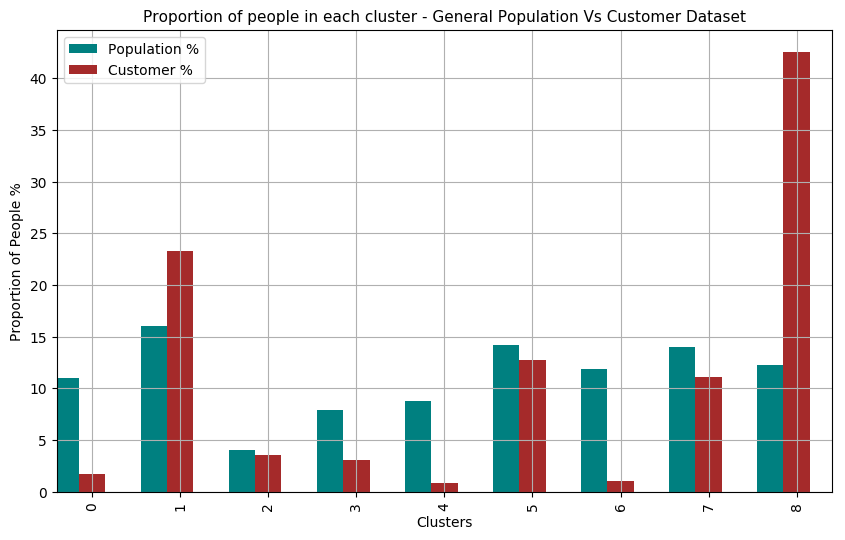

In [104]:
# Plot bar charts

# Visualize % people in each cluster for the Population and Customer Dataset

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = df_clust_props['Population%'].plot(x=df_clust_props.index.values, kind='bar',color='teal',width=-0.3, align='edge',position=0)
ax = df_clust_props['Customers%'].plot(kind='bar',color='brown',width = 0.3, align='edge',position=1)
ax.set_ylabel('Proportion of People %', fontsize=10)
ax.set_xlabel('Clusters', fontsize=10) 
ax.grid(which="major")
plt.legend(('Population %', 'Customer %'),fontsize=10)
plt.title(('Proportion of people in each cluster - General Population Vs Customer Dataset'),fontsize=11);


In [105]:
# Get row count of higher than threshold missing rows from population dataset
pop_missvals_rowcount = azdias_missvals_abvthresh.shape[0]
pop_missvals_rowcount

109941

In [106]:
# Get row count of higher than threshold missing rows from customer dataset
cust_missvals_rowscount = cust_high_missvals.shape[0]
cust_missvals_rowscount

52423

In [107]:
# Add above rowcounts as an extra cluster to dataframe

cust_clust_new = cust_clust_count.copy()
cust_clust_new.loc[cust_clust_new.index.max()+1] = cust_missvals_rowscount
cust_clust_prop = round((cust_clust_new/cust_clust_new.sum())*100,2)
#print(cust_clust_prop)

pop_clust_new = pop_clust_count.copy()
pop_clust_new.loc[pop_clust_new.index.max()+1] = pop_missvals_rowcount
pop_clust_prop = round((pop_clust_new/pop_clust_new.sum())*100,2)
#print(pop_clust_prop)

# Concatenate population and customer data proportions for side-by-side comparison
df_clust_props_new = pd.concat([pop_clust_prop, cust_clust_prop], axis=1)
df_clust_props_new.columns = ['Population%','Customers%']
df_clust_props_new.index.name = 'Cluster'
print(df_clust_props_new)

         Population%  Customers%
Cluster                         
0               9.62        1.22
1              14.02       16.94
2               3.58        2.61
3               6.90        2.22
4               7.73        0.60
5              12.41        9.28
6              10.38        0.78
7              12.26        8.09
8              10.77       30.90
9              12.34       27.35


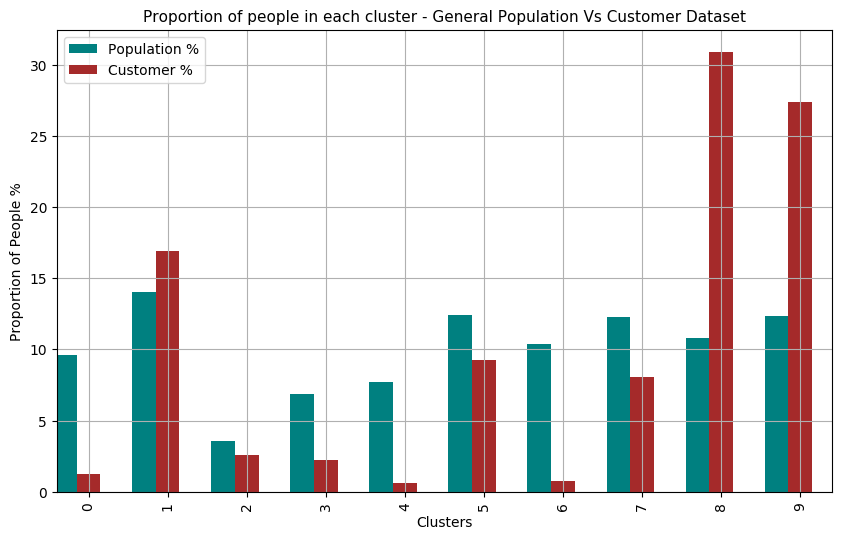

In [108]:
# Visualize ratios for each cluster

# Plot bar charts

# Visualize % people in each cluster for the Population and Customer Dataset

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = df_clust_props_new['Population%'].plot(x=df_clust_props_new.index.values, kind='bar',color='teal',width=-0.3, align='edge',position=0)
ax = df_clust_props_new['Customers%'].plot(kind='bar',color='brown',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=10) 
ax.set_ylabel('Proportion of People %', fontsize=10)
ax.grid(which="major")
plt.legend(('Population %', 'Customer %'),fontsize=10)
plt.title(('Proportion of people in each cluster - General Population Vs Customer Dataset'),fontsize=11);


In [109]:
kmeans_9.cluster_centers_.shape

(9, 60)

###### Cluster that has dominant representation of Customer data compared to General Population data

In [110]:
# What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?
# Cluster 8 is clearly overrepresented by Customer data and cluster 9 (missing values) as well

# Find principal components of cluster 8 
pc_c8 = kmeans_9.cluster_centers_[8]  # returns principal components associated with cluster# 8
pc_c8 = pd.Series(pc_c8)
pc_c8.index = pc_c8.index + 1

In [111]:
# Get back the mapped feature values by taking inverse transforms
feat_vals = scaler.inverse_transform(pca_60.inverse_transform(pc_c8))
feat_vals = pd.Series(feat_vals).round(4)
df_feat_vals = pd.DataFrame(feat_vals)
df_feat_vals.index = customers_clean.columns
df_feat_vals.index.name = 'Features'
df_feat_vals.columns = ['Values']

In [112]:
df_feat_vals

,Values
Features,
ALTERSKATEGORIE_GROB,3.3963
ANREDE_KZ,1.4974
FINANZ_MINIMALIST,4.5425
FINANZ_SPARER,1.5119
FINANZ_VORSORGER,4.3800
FINANZ_ANLEGER,1.7051
FINANZ_UNAUFFAELLIGER,2.0002
FINANZ_HAUSBAUER,2.2208
GREEN_AVANTGARDE,0.9955


In [113]:
# Let us see how to the feature values representing to this cluster compare with respect to the mean values across entire dataset
df_cust = pd.DataFrame(df_customers_imp ,columns = customers_clean.columns)
#getting the mean values of all features across the entire data set
df_feat_vals['Mean'] = df_cust.mean()
df_feat_vals['Ratio'] = df_feat_vals['Values']/df_feat_vals['Mean']

In [115]:
# Finding the first few features that have values > 30% of the mean values of the features in complete dataset
df_feat_vals[df_feat_vals['Ratio'] > 1.3].sort_values('Ratio',ascending=False)

,Values,Mean,Ratio
Features,,,
ZABEOTYP_2,0.1189,0.047504,2.502922
LP_STATUS_GROB_5.0,0.7830,0.368135,2.126940
LP_FAMILIE_GROB_3.0,0.0211,0.010465,2.016288
GREEN_AVANTGARDE,0.9955,0.501404,1.985424
AVANTGARDE,0.9957,0.503115,1.979069
CAMEO_DEUG_2015_2,0.2746,0.166740,1.646878
CJT_GESAMTTYP_6.0,0.1120,0.071156,1.574003
FINANZTYP_4,0.0195,0.012778,1.526119
FINANZTYP_3,0.0392,0.027839,1.408095


###### Cluster that has very low representation of Customer data compared to General Population data

In [116]:
# What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?
# Clearly cluster 6 is significantly under represented followed by cluster 0
# Find principal components of cluster 6
pc_c6 = kmeans_9.cluster_centers_[6]  # returns principal components associated with cluster# 6
pc_c6= pd.Series(pc_c6)
pc_c6.index = pc_c6.index + 1


In [117]:
# Get back the mapped feature values by taking inverse transforms
feat_vals = scaler.inverse_transform(pca_60.inverse_transform(pc_c6))
feat_vals = pd.Series(feat_vals).round(4)
df_feat_vals = pd.DataFrame(feat_vals)
df_feat_vals.index = customers_clean.columns
df_feat_vals.index.name = 'Features'
df_feat_vals.columns = ['Values']

# Let us see how to the feature values representing to this cluster compare with respect to the mean values across entire dataset
df_cust = pd.DataFrame(df_customers_imp ,columns = customers_clean.columns)
#getting the mean values of all features across the entire data set
df_feat_vals['Mean'] = df_cust.mean()
df_feat_vals['Ratio'] = df_feat_vals['Values']/df_feat_vals['Mean']

In [118]:
# Finding the first few features that have values > 3 times of the mean values of the features in complete dataset
df_feat_vals[df_feat_vals['Ratio'] > 3].sort_values('Ratio',ascending=False)

,Values,Mean,Ratio
Features,,,
ZABEOTYP_5,0.2918,0.006773,43.082738
FINANZTYP_1,0.7787,0.027573,28.241110
NATIONALITAET_KZ_3.0,0.1141,0.009861,11.570305
NATIONALITAET_KZ_2.0,0.1526,0.016570,9.209513
LP_STATUS_GROB_1.0,0.9680,0.136444,7.094471
CAMEO_DEUG_2015_9,0.3105,0.045041,6.893734
GFK_URLAUBERTYP_12.0,0.3113,0.045213,6.885145
LP_FAMILIE_GROB_3.0,0.0662,0.010465,6.325985
FINANZTYP_4,0.0628,0.012778,4.914885


### Discussion 3.3: Compare Customer Data to Demographics Data

Reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

- From the plot that displayed proportion of people (both Customer demographics and General Populatiom) vs the number of clusters that are recommended by K-means algorithm, it is clear that cluster# 8 contains a strong representation in customer dataset and cluster# 6 has the least representation in customer dataset when compared to the general population. Also the proportion of people with missing values for features have a higher representation in customer dataset.


- Cluster# 8 : As mentioned above, this cluster has a strong representation in customer dataset, hence if we know the segment of people that can be characterized by this cluster, we can target this segment of people for marketing. Hence we found out the features that have a dominant presence - to determine them, we compared the feature values in the cluster with the average or mean value of the corresponding features across the entire customer dataset. Then we selected only those that exceeded the mean by 30% as the donminant features to characterize the segment. 

 The people that come under this segment seems to be people with high incomes and upper/upper- middle class social status  staying in neighbourhood areas that are low-density with 1-2 family homes. These people also seem to favor an eco-friendly (green/recycle) energy  and have original/open to experimentation mindset. They are mostly home-owners, non-flashy and have a good financial preparedness.
 
 
-  Cluster# 6 : As mentioned above, this cluster has a low representation in customer dataset, hence if we know the segment of people that can be characterized by this cluster, we can avoid marketing to this segment of people for now. Hence we found out the features that have a dominant presence - to determine them, we compared the feature values in the cluster with the average or mean value of the corresponding features across the entire customer dataset. Then we selected only those that exceeded the mean by 3 times as the donminant features to characterize the segment. 

  The people that come under this segment seems to be people with low incomes and working/working urban background,  staying in neighbourhood areas that have higher-density with 6+ and 10+  family homes. These people also seem to be lacking awareness of (green/recycle) energy  and are price-sensitive. They are mostly single-parent families and have a poor financial literacy. Another thing is that this segment contains an above average presence of people that do not have a German ethnicity.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.